# <span style="color:darkred"> Laboratorio di Simulazione Numerica </span>
## <span style="color:darkorange">  Esercitazione 8</span>

In questa esercitazione ho ottimizzato il ground state di una singola particella in una dimensione descritta da una Hamiltoniana del tipo:

$$ H(x) = -\frac{\hbar^2}{2 m} \frac{d^2}{dx^2} + x^4 - \frac{5}{2}x^2\ .$$

Tale sistema non è analiticamente risolvibile e si ricorre così a metodi numerici e variazionali. Il metodo Variazionale Monte Carlo, conoscendo il potenziale, utilizza una funzione d'onda di prova parametrizzata. Nel caso del potenziale sopra scritto un buon modello approssimativo del ground state è la somma di due gaussiane:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+e^{-\frac{(x+\mu)^2}{2\sigma^2}}\ .
$$

I parametri da cui dipende la funzione d'onda sono $\mu$, distanza dall'origine dei picchi delle gaussiane, e $\sigma$ che è la deviazione standard.

## 08.1
Nel primo esercizio ho scritto un codice per valutare:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}\ .
$$

Mi sono servita del metodo di Metropolis per campionare la distribuzione $\bigl|\Psi_T^{\sigma,\mu}(x)\bigr|^2$, scritta come la somma delle due gaussiane e con probabilità di transizione uniforme. Il mio codice legge in *Input* i parametri $\mu$ e $\sigma$ iniziali, il punto $x_0$ iniziale da cui partire per campionare, la grandezza $\delta$ del passo di Metropolis, il numero di blocchi e il numero di step per blocco. Effettua una procedura di ottimizzazione dei parametri $\mu$ e $\sigma$ (descritta nell'esercizio $8.02$) e con i nuovi valori calcola la media dell'Hamiltoniana. Esegue un ciclo esterno sui blocchi e uno interno sugli step per blocco. Con la funzione *Accumulate* all'interno di ogni blocco accumulo le stime dell'energia e con la funzione *Averages* ne calcolo poi la media e l'errore. All'inizio del ciclo sui blocchi vi è la funzione *Reset* che azzera gli accumulatori.

## 08.2
Ho implementato una funzione che trovasse i parametri $\mu$ e $\sigma$ che minimizzassero $\langle {\hat H} \rangle_T$, in modo da avvicinarsi sempre di più all'energia dello stato fondamentale. In particolare ho implementato il metodo del *Simulated Annealing* (che spiego in modo accurato nell'esercizio $10.1$): ho campionato tramite il Metropolis due nuovi valori $\mu '$ e $\sigma '$ con probabilità di transizione uniforme e ho calcolato il valore della funzione $E(x, \mu, \sigma) = \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)}$ che ho usato come energia nel peso di Boltzmann. Ho accettato i nuovi parametri proposti con probabilità $e^{-\beta(E(\mu', \sigma')-E(\mu, \sigma))}$ se $E(\mu', \sigma')>E(\mu, \sigma)$, altrimenti con probabilità $1$. Tramite un ciclo esterno ho diminuito lentamente la temperatura e in questo modo il sistema va a campionare nuovi parametri affinchè l'energia sia sempre più vicina al minimo. In particolare all'interno della funzione di equilibrazione ho eseguito un ciclo di $100$ temperature e per ogni temperatura ho campionato $100$ volte diversi $\mu$ e $\sigma$, aggiornando il loro valore qualora fossero accettati. In questo modo, una volta eseguita l'equilibrazione i parametri letti per poter calcolare il valore medio dell'energia sono quelli ottimizzati. Ho riportato il grafico dell'energia con il rispettivo errore in funzione del numero di blocchi. Pur avendo un valore molto vicino all'energia esatta di ground state, la curva rimane un limite superiore.

Ho inoltre salvato su un istogramma le posizioni campionate dalla distribuzione $\bigl|\Psi_T^{\sigma,\mu}(x)\bigr|^2$. Il grafico rappresenta tale istogramma campionato, la soluzione ottenuta trasformando l'equazione di Schroedinger in una equazione matriciale e la soluzione analitica per la quale ho calcolato a mano la normalizzazione.


mu = 0.809209
sigma = 0.622038



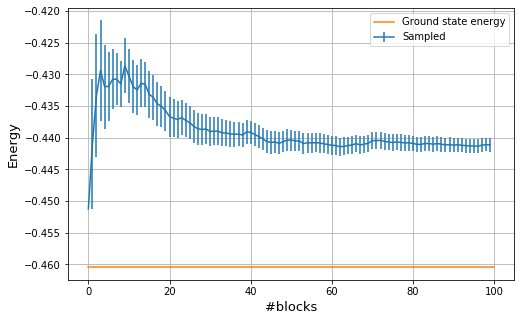

In [121]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math

plt.figure(figsize=(8, 5))
(Hmedia, err_Hmedia) = np.loadtxt('H_mean.dat', unpack=True, usecols=(1,2))
x = np.arange(len(Hmedia))
plt.errorbar(x, Hmedia, yerr=err_Hmedia, label = 'Sampled')
plt.plot([0, len(Hmedia)], [-0.46046587969271563, -0.46046587969271563], label = 'Ground state energy')
plt.ylabel('Energy', fontsize=13)
plt.xlabel('#blocks', fontsize=13)
plt.legend()
plt.grid()
print()
print('mu = 0.809209')
print('sigma = 0.622038')
print()

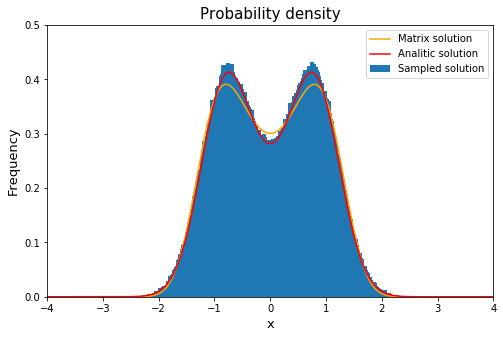

In [122]:
def Vpot(x):
    return (x**2 - 2.5)*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2
CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

plt.figure(figsize=(8,5))
scale = 0.3
plt.plot(x,(psi[0])**2, color = 'orange', label='Matrix solution')
plt.xlim((-4, 4))
plt.ylim((0, 0.5))

def Psi(x, mu, sigma):
    return np.exp(-(x-mu)*(x-mu)/(2.*sigma*sigma))+np.exp(-(x+mu)*(x+mu)/(2.*sigma*sigma))

def Psi_Quadro(x, mu, sigma):
    return Psi(x, mu, sigma)*Psi(x, mu, sigma)

mu = 0.809209
sigma = 0.622038
normalizzazione = 2.*np.sqrt(math.pi)*sigma*(1. + np.exp(-mu*mu/(sigma*sigma)))
(r, isto) = np.loadtxt('istogramma.dat', unpack=True, usecols=(0, 1))

plt.plot(x, Psi_Quadro(x, mu, sigma)/normalizzazione, color='red', label = 'Analitic solution')
plt.bar(r, isto, align='center', width=0.08, label="Sampled solution")
plt.legend()
plt.title('Probability density', fontsize=15)
plt.xlabel('x', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.show()

## 08.3

Ho utilizzato il codice fornitomi per simulare la dinamica di un sistema quantistico in una dimensione. In particolare ho aggiunto al codice il potenziale $V(x)$ relativo a questa esercitazione e la funzione d'onda di prova con i parametri $\mu$ e $\sigma$ da me ottimizzati.

Ho poi eseguito una simulazione PIGS (*Path Integral Ground State*), che lavora a $T=0$, sia con la funzione d'onda di prova costante $\Psi_T(x) = 1$ sia con quella scritta come somma delle due gassiane. Ho riportato il grafico delle densità di probabilità ottenute e di quella ottenuta dalla soluzione matriciale e le ho trovate in perfetto accordo.
Ho anche riportato l'energia totale, che ho calcolato sommando quella cinetica e potenziale ottenute dalla simulazione e calcolandone l'errore come la somma inquadratura.

Successivamente ho variato il tempo di propagazione immaginario, al fine di osservare quale fosse il tempo minimo per entrambe le funzioni d'onda per cui si potesse ottenere una soluzione per la densità di probabilità compatibile con quella esatta del ground state. Facendo evolvere la funzione d'onda di prova a grandi tempi immaginari infatti, accade che essa diventa proporzionale a quella del ground state. Ho osservato dai grafici che approssimando come somma di gaussiane la funzione d'onda si può scendere fino a tempi di propagazione pari a $t = 2.5$ per avere un risultato accettabile e infatti nei grafici con tempi minori di tale valore si osservano incompatibilità. Approssimando invece con la funzione d'onda costante si hanno risultati accettabili solo sopra a $t=4$. Mi aspettavo una propagazione di tempi maggiori per la funzione d'onda costante rispetto a quella gaussina, poichè la prima non è una buona approssimazione dello stato fondamentale.

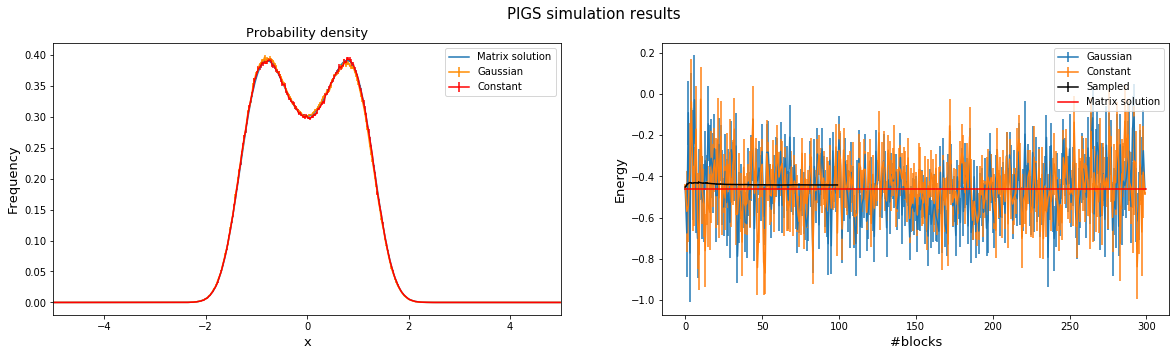

In [123]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
fig.suptitle('PIGS simulation results', fontsize=15)

(x0, P0, errP0) = np.loadtxt('QMC_1D/PIGS/probability_gauss_PIGS.dat', unpack=True, usecols=(0, 1, 2))
(x1, P1, errP1) = np.loadtxt('QMC_1D/PIGS/probability_const_PIGS.dat', unpack=True, usecols=(0, 1, 2))

x = np.linspace(-a/2, a/2, N)
axs[0].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[0].errorbar(x0, P0, yerr=errP0, label='Gaussian', color='darkorange')
axs[0].errorbar(x1, P1, yerr=errP1, label='Constant', color='red')
axs[0].set_xlim([-5,5])
axs[0].set_title('Probability density', fontsize=13)
axs[0].set_xlabel('x', fontsize=13)
axs[0].set_ylabel('Frequency', fontsize=13)

(x0, E0, errE0) = np.loadtxt('QMC_1D/PIGS/potential_gauss_PIGS.dat', unpack=True, usecols=(0, 1, 2))
(x0, K0, errK0) = np.loadtxt('QMC_1D/PIGS/kinetic_gauss_PIGS.dat', unpack=True, usecols=(0, 1, 2))
(x1, E1, errE1) = np.loadtxt('QMC_1D/PIGS/potential_const_PIGS.dat', unpack=True, usecols=(0, 1, 2))
(x1, K1, errK1) = np.loadtxt('QMC_1D/PIGS/kinetic_const_PIGS.dat', unpack=True, usecols=(0, 1, 2))

E0_tot = E0 + K0
err_E0_tot = np.sqrt(errE0*errE0 + errK0*errK0)
E1_tot = E1 + K1
err_E1_tot = np.sqrt(errE1*errE1 + errK1*errK1)

x=np.arange(len(Hmedia))
axs[1].errorbar(x0, E0_tot, yerr=err_E0_tot, label='Gaussian')
axs[1].errorbar(x1, E1_tot, yerr=err_E1_tot, label='Constant')
axs[1].errorbar(x, Hmedia, yerr=err_H, label = 'Sampled', color='black')
axs[1].errorbar([0, len(E0_tot)], [-0.46046587969271563, -0.46046587969271563], label = 'Matrix solution', color='red')
axs[1].set_xlabel('#blocks', fontsize=13)
axs[1].set_ylabel('Energy', fontsize=13)

for ax in axs.flat:
    ax.legend()

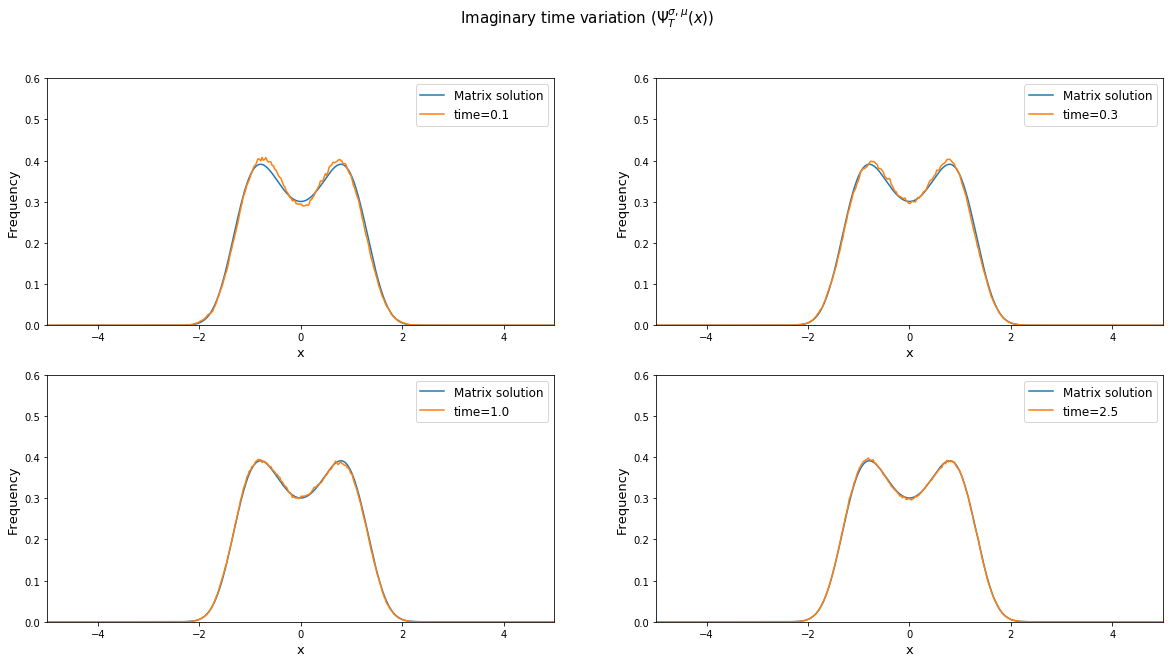

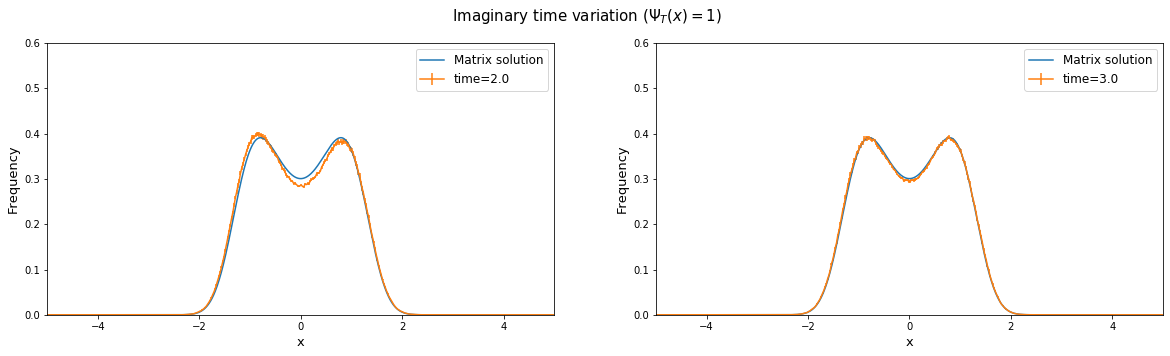

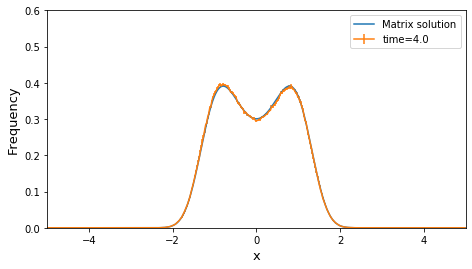

In [124]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
plt.suptitle('Imaginary time variation ($\Psi_{T}^{\sigma, \mu}(x)$)', fontsize=15)
(x01, P01, errP01) = np.loadtxt('QMC_1D/PIGS/time01_gauss.dat', unpack=True, usecols=(0, 1, 2))
(x03, P03, errP03) = np.loadtxt('QMC_1D/PIGS/time03_gauss.dat', unpack=True, usecols=(0, 1, 2))
(x1, P1, errP1) = np.loadtxt('QMC_1D/PIGS/time1_gauss.dat', unpack=True, usecols=(0, 1, 2))
(x2_5, P2_5, errP2_5) = np.loadtxt('QMC_1D/PIGS/time2_5_gauss.dat', unpack=True, usecols=(0, 1, 2))

x = np.linspace(-a/2, a/2, N)

axs[0,0].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[0,0].errorbar(x01, P01, label = 'time=0.1')

axs[0,1].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[0,1].errorbar(x03, P03, label = 'time=0.3')

axs[1,0].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[1,0].errorbar(x1, P1, label = 'time=1.0')

axs[1,1].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[1,1].errorbar(x2_5, P2_5, label = 'time=2.5')

for ax in axs.flat:
    ax.set_xlim(-5,5)
    ax.set_ylim(0, 0.6)
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.legend(fontsize='large')
    
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('Imaginary time variation ($\Psi_{T}(x) = 1$)', fontsize=15)
(x2, P2, errP2) = np.loadtxt('QMC_1D/PIGS/time2_const.dat', unpack=True, usecols=(0, 1, 2))
(x3, P3, errP3) = np.loadtxt('QMC_1D/PIGS/time3_const.dat', unpack=True, usecols=(0, 1, 2))
(x4, P4, errP4) = np.loadtxt('QMC_1D/PIGS/time4_const.dat', unpack=True, usecols=(0, 1, 2))

x = np.linspace(-a/2, a/2, N)

axs[0].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[0].errorbar(x2, P2, yerr=errP2, label = 'time=2.0')

axs[1].errorbar(x,(psi[0])**2, label='Matrix solution')
axs[1].errorbar(x3, P3, yerr=errP3, label = 'time=3.0')

for ax in axs.flat:
    ax.set_xlim(-5,5)
    ax.set_ylim(0, 0.6)
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.legend(fontsize='large')

plt.figure(figsize=(7.5, 4))
plt.errorbar(x,(psi[0])**2, label='Matrix solution')
plt.errorbar(x4, P4, yerr=errP4, label = 'time=4.0')
plt.xlim(-5, 5)
plt.ylim(0, 0.6)
plt.xlabel('x', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.legend(fontsize='medium')
plt.show()

Ho poi eseguito una simulazione PIMC (*Path Integral Monte Carlo*) che lavora a temperatura $T>0$. Ho eseguito tale simulazione solo per la funzione d'onda $\Psi_T^{\sigma,\mu}(x)$. Ho graficato l'energia totale calcolandola analogamente a quanto fatto in precedenza e l'ho paragonata con l'energia ottenuta con una simulazione PIGS. Ho ottenuto un valore maggiore poichè a temperatura diversa da zero vengono esplorati anche gli stati eccitati e inoltre la funzione d'onda è una miscela di funzioni di stati diversi. Ciò si capisce ancora di più osservando la distribuzione di probabilità al crescere della temperatura. Infatti, poichè vado a esplorare gli stati eccitati, questa si allarga e appiattisce.

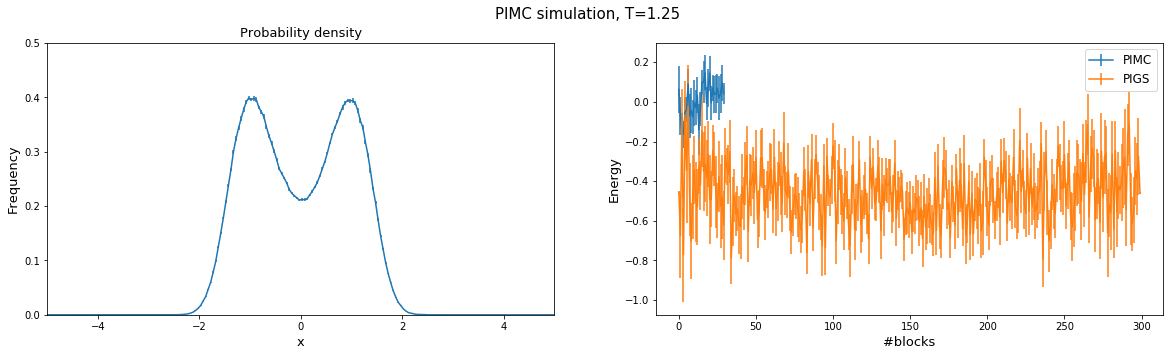

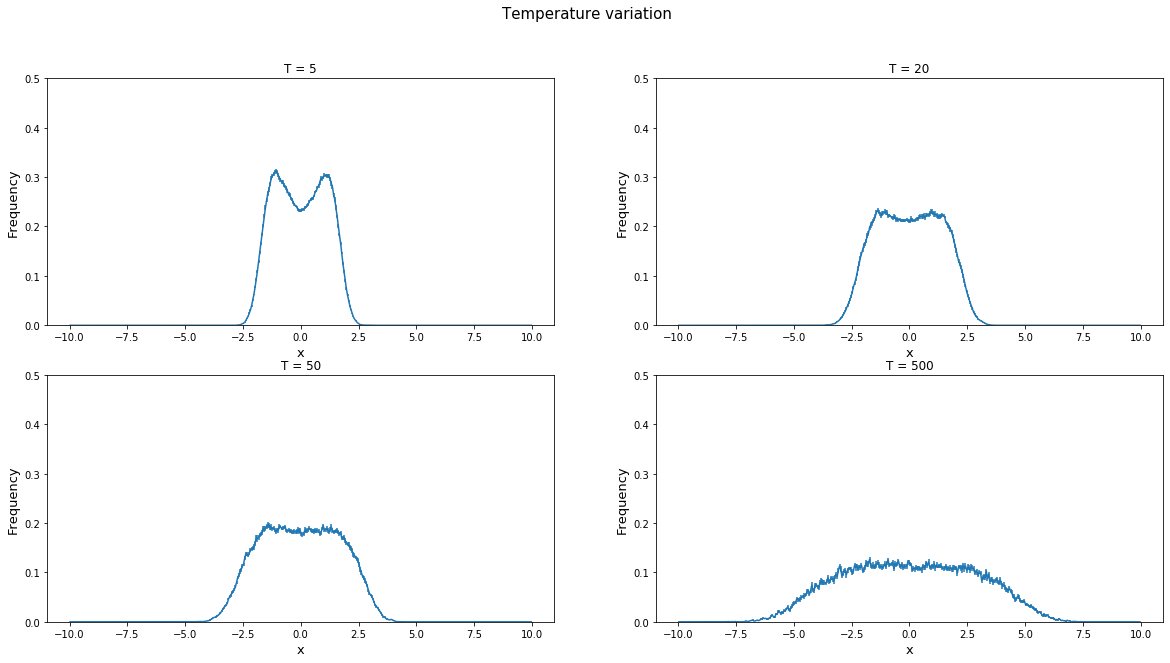

In [125]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
plt.suptitle('PIMC simulation, T=1.25', fontsize=15)

(x, P, errP) = np.loadtxt('QMC_1D/PIMC/probability_gauss_PIMC.dat', unpack=True, usecols=(0, 1, 2))
axs[0].errorbar(x, P, yerr=errP)
axs[0].set_title('Probability density', fontsize=13)
axs[0].set_xlim(-5,5)
axs[0].set_ylim(0, 0.5)
axs[0].set_xlabel('x', fontsize=13)
axs[0].set_ylabel('Frequency', fontsize=13)

(x0, E0, errE0) = np.loadtxt('QMC_1D/PIMC/potential_gauss_PIMC.dat', unpack=True, usecols=(0, 1, 2))
(x0, K0, errK0) = np.loadtxt('QMC_1D/PIMC/kinetic_gauss_PIMC.dat', unpack=True, usecols=(0, 1, 2))

E0_tot = E0 + K0
err_E0_tot = np.sqrt(errE0*errE0 + errK0*errK0)

(x1, E1, errE1) = np.loadtxt('QMC_1D/PIGS/potential_gauss_PIGS.dat', unpack=True, usecols=(0, 1, 2))
(x1, K1, errK1) = np.loadtxt('QMC_1D/PIGS/kinetic_gauss_PIGS.dat', unpack=True, usecols=(0, 1, 2))
E1_tot = E1 + K1
err_E1_tot = np.sqrt(errE1*errE1 + errK1*errK1)

axs[1].errorbar(x0, E0_tot, yerr=err_E0_tot, label='PIMC')
axs[1].errorbar(x1, E1_tot, yerr=err_E1_tot, label='PIGS')
axs[1].set_xlabel('#blocks', fontsize=13)
axs[1].set_ylabel('Energy', fontsize=13)
axs[1].legend(fontsize='large')

fig, axs = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Temperature variation', fontsize=15)

(x5, P5, errP5) = np.loadtxt('QMC_1D/PIMC/probability_T5_PIMC.dat', unpack=True, usecols=(0, 1, 2))
(x20, P20, errP20) = np.loadtxt('QMC_1D/PIMC/probability_T20_PIMC.dat', unpack=True, usecols=(0, 1, 2))
(x50, P50, errP50) = np.loadtxt('QMC_1D/PIMC/probability_T50_PIMC.dat', unpack=True, usecols=(0, 1, 2))
(x500, P500, errP500) = np.loadtxt('QMC_1D/PIMC/probability_T500_PIMC.dat', unpack=True, usecols=(0, 1, 2))

axs[0,0].errorbar(x5, P5, yerr=errP5)
axs[0,0].set_title('T = 5')
axs[0,1].errorbar(x20, P20, yerr=errP20)
axs[0,1].set_title('T = 20')
axs[1,0].errorbar(x50, P50, yerr=errP50)
axs[1,0].set_title('T = 50')
axs[1,1].errorbar(x500, P500, yerr=errP500)
axs[1,1].set_title('T = 500')

for ax in axs.flat:
    ax.set_xlabel('x', fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.set_ylim(0, 0.5)